In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/itba-cifar-100-2024-q-1/y_train_fine.npy
/kaggle/input/itba-cifar-100-2024-q-1/y_train_coarse.npy
/kaggle/input/itba-cifar-100-2024-q-1/fine_label_names.pck
/kaggle/input/itba-cifar-100-2024-q-1/coarse_label_names.pck
/kaggle/input/itba-cifar-100-2024-q-1/x_test.npy
/kaggle/input/itba-cifar-100-2024-q-1/x_train.npy


In [28]:
x_train = np.load("/kaggle/input/itba-cifar-100-2024-q-1/x_train.npy")/255.
x_test = np.load("/kaggle/input/itba-cifar-100-2024-q-1/x_test.npy")/255.
y_train_coarse = np.load("/kaggle/input/itba-cifar-100-2024-q-1/y_train_coarse.npy")
y_train_fine = np.load("/kaggle/input/itba-cifar-100-2024-q-1/y_train_fine.npy")

In [29]:
import pickle
with open("/kaggle/input/itba-cifar-100-2024-q-1/fine_label_names.pck", "rb") as f:
    labels_fine = pickle.load(f)
with open("/kaggle/input/itba-cifar-100-2024-q-1/coarse_label_names.pck", "rb") as f:
    labels_coarse = pickle.load(f)

In [30]:
from matplotlib import pyplot as plt
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


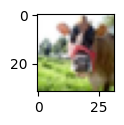

In [31]:
plt.figure(figsize=(1,1))
plt.imshow(x_train[0])

In [32]:
x_train[0].shape

(32, 32, 3)

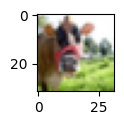

In [33]:
x_train_0_inverted =  np.fliplr(x_train[0])
plt.figure(figsize=(1,1))
plt.imshow(x_train_0_inverted)

## Divide in Train and Validation

In [34]:
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    x_train, y_train_fine, test_size=0.2, random_state=42, stratify=y_train_fine)

In [35]:
X_train.shape

(40000, 32, 32, 3)

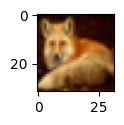

In [36]:
plt.figure(figsize=(1,1))
plt.imshow(X_train[0])

## Probando Data Aumegtation con Keras

Debido a la baja resolución de la imágenes, se intentará hacerles un zoom pequeño, rotaciones de pequeños valores de ángulos y flip horizontales.

Uncomment this section if ImageDataGenerator for Data Augmentation is to be used

In [37]:
# Uncomment this section if ImageDataGenerator for Data Augmentation is to be used

# Importing necessary functions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

# Initialising the ImageDataGenerator class.
# We will pass in the augmentation parameters in the constructor.
datagen = ImageDataGenerator(
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range = 0.1,
        horizontal_flip=True)

# i = 0
# for batch in datagen.flow(X_train, y_train, batch_size=2):
#     i+=1
#     if i == 0:
#         plt.figure(figsize=(1,1))
#         plt.imshow(batch[0][0])
#         break


## Add flipped images to train (if no data generator used)

In [38]:
# X_train_extended = [np.fliplr(x) for x in X_train]
# X_train = np.concatenate((X_train, X_train_extended), axis=0)
# X_train.shape

In [39]:
# y_train = np.concatenate((y_train, y_train), axis=0)

In [40]:
y_train.shape

(40000,)

In [41]:
y_train[0]

34

In [42]:
labels_fine[y_train[0]]

'fox'

In [43]:
'''# Me fijo para una categoría de grano grueso, cuáles son las categorías de grano fino
coarse = 6
print(f"Grano grueso: {labels_coarse[coarse]}")
for fine in np.unique(y_train[y_train_coarse == coarse]):
    print(f"Grano fino: {labels_fine[fine]}")'''

# Dará error, puesto que ahora X_train e y_train cambiaron

'# Me fijo para una categoría de grano grueso, cuáles son las categorías de grano fino\ncoarse = 6\nprint(f"Grano grueso: {labels_coarse[coarse]}")\nfor fine in np.unique(y_train[y_train_coarse == coarse]):\n    print(f"Grano fino: {labels_fine[fine]}")'

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard

In [45]:
X_train.shape

(40000, 32, 32, 3)

## Model creation

1)  Se probaron varios modelos, hasta obtener el modelo secuencial que tiene 32* 32* 3 neuronas a la entrada (mismo tamaño que el input), 2 capas intermedias con tamaños 32* 32* 2 y 32* 32 (es decir, se van reduciendo de a 1/2), y una capa de salida de 100. Para este modelo, se llegaba a 0.22 en CV, y el train llegaba a aprox 0.7. Si se lo dejaba correr sin Early Stopping, el accuracy llegaba a 0.99, habiendo un claro overfitting.

2) Se agregaron a las primeras 2 capas, que poseen mayor cantidad de neuronas, regularización l2. Aumentó ligeramente a 0.24240 el accuracy de CV. Se probó con L1 en la primera capa, pero tenía una peor performance.

3) Se probó luego con Dropout, pero el ritmo de mejora del accuracy era demasiado lento, por lo que se intentó otro camino.

4) Se agregó Batch Normalization a la salida de cada capa. Se utilizó un BatchSize de 64. Se decidió hacer esto puesto que el modelo posee muchos pesos y el overfitting es muy grande. Se llegó a 0.3329 en CV.

5) Sólo como modo de prueba, sabiendo que es una mala práctica cobinar Dropout con Batch normalization, se decidió agregar ahora sí DropOut, luego de cada función de activación. Con 0.4, 0.3 y 0.2 se llegó a 0.35 de Accuracy en CV. Con 0.5, 0.4 y 0.3, a 0.35790 CV. Con 0.5, 0.5 y 0.5, a 0.36230 en CV. Sin embargo, Train ahora llega a 0.6 de Accuracy, lo cual indica que habría que mejorar el modelo.


7) Ahora eliminamos el DropOut  y dejamos solo Batch Normalization. Se decidió ahora generar las imágenes con el ImageDataGenerator, usando los shifts verticales y horizontales, como el flip horizontal y rotación de ángulo. (Con poca variación, debido a la baja resolución de las imágenes). Por estar usando el generador para Data Aumegtation, se tuvo que aumentar la complejidad de la red. Agregar una capa de 512 empeoró el Accuracy de ambos. Agregar una de 1024 igualó al de CV más alto hallado anteriormente, pero empeoró el de train. Finalmente, se aumentó a 32* 32* 3,32* 32* 2 y 32* 32* 1.

8) El resultado final fue de: 0.37390 en CV y 0.8673 en Train; y este fue el modelo final para la parte de MLP.

In [46]:
from keras.regularizers import l2, l1
from keras.layers import Dropout,  BatchNormalization, Activation
from keras.constraints import max_norm


model = Sequential()
# Flatten turns the input shape to a single vector
model.add(Flatten(input_shape=(32,32,3)))
model.add(Dense(32*32*4))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(32*32*3, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(32*32*2, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(100, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('softmax'))

model.compile(loss="sparse_categorical_crossentropy", metrics = ["accuracy"], optimizer = Adam(learning_rate=0.001))


#############################################
# 0.36410 CV (Con drop-out)
#############################################
# model = Sequential()
# # Flatten turns the input shape to a single vector
# model.add(Flatten(input_shape=(32,32,3)))
# model.add(Dense(32*32*4, kernel_constraint = max_norm(5)))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.5))

# model.add(Dense(32*32*3, use_bias=False, kernel_constraint = max_norm(5)))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.5))

# model.add(Dense(32*32*2, use_bias=False, kernel_constraint = max_norm(5)))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.5))

# model.add(Dense(100, use_bias=False))
# model.add(BatchNormalization())
# model.add(Activation('softmax'))

# model.compile(loss="sparse_categorical_crossentropy", metrics = ["accuracy"], optimizer = Adam(learning_rate=0.001))

#############################################
# 0.36230 CV (Con drop-out)
#############################################

# model = Sequential()
# # Flatten turns the input shape to a single vector
# model.add(Flatten(input_shape=(32,32,3)))
# model.add(Dense(32*32*3))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.5))

# model.add(Dense(32*32*2, use_bias=False))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.5))

# model.add(Dense(32*32, use_bias=False))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.5))

# model.add(Dense(100, use_bias=False))
# model.add(BatchNormalization())
# model.add(Activation('softmax'))

# model.compile(loss="sparse_categorical_crossentropy", metrics = ["accuracy"], optimizer = Adam(learning_rate=0.001))

#############################################
# 0.33290 CV, luego de 63 Epochs (Early Stopping)
#############################################
# model = Sequential()
# # Flatten turns the input shape to a single vector
# model.add(Flatten(input_shape=(32,32,3)))
# model.add(Dense(32*32*3))
# model.add(BatchNormalization())
# model.add(Activation('relu'))

# model.add(Dense(32*32*2, use_bias=False))
# model.add(BatchNormalization())
# model.add(Activation('relu'))

# model.add(Dense(32*32,  use_bias=False))
# model.add(BatchNormalization())
# model.add(Activation('relu'))

# model.add(Dense(100, activation="softmax", use_bias=False))
# model.compile(loss="sparse_categorical_crossentropy", metrics = ["accuracy"], optimizer = Adam(learning_rate=0.001))

#############################################
# 0.28510 CV
#############################################
# model = Sequential()
# # Flatten turns the input shape to a single vector
# model.add(Flatten(input_shape=(32,32,3)))
# model.add(Dense(32*32*3, kernel_regularizer=l2(0.001)))
# model.add(BatchNormalization())
# model.add(Activation('relu'))

# model.add(Dense(32*32*2, kernel_regularizer=l2(0.001), use_bias=False))
# model.add(BatchNormalization())
# model.add(Activation('relu'))

# model.add(Dense(32*32, kernel_regularizer=l2(0.001),  use_bias=False))
# model.add(BatchNormalization())
# model.add(Activation('relu'))

# model.add(Dense(100, activation="softmax",  use_bias=False))
# model.compile(loss="sparse_categorical_crossentropy", metrics = ["accuracy"], optimizer = Adam(learning_rate=0.001))

##########################################
# Mejor modelo hasta ahora (0.25390 en CV)
##########################################
# from keras.regularizers import l2, l1

# model = Sequential()
# # Flatten turns the input shape to a single vector
# model.add(Flatten(input_shape=(32,32,3)))
# # 32*32*3 como primera capa - val_accuracy: 0.2374 (y no parece haber overfitting notorio (linea_recta))
# model.add(Dense(32*32*3, activation="relu", kernel_regularizer=l2(0.001)))
# model.add(Dense(32*32*2, activation="relu", kernel_regularizer=l2(0.001)))
# model.add(Dense(32*32, activation="relu",  kernel_regularizer=l2(0.001)))
# model.add(Dense(100, activation="softmax"))
# model.compile(loss="sparse_categorical_crossentropy", metrics = ["accuracy"], optimizer = Adam(learning_rate=0.001))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [47]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4096)           │    12,587,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3072)           │    12,582,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 3072)           │        12,288 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2048)           │     6,291,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 100)            │       204,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 100)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,703,440 (120.94 MB)

 Trainable params: 31,684,808 (120.87 MB)

 Non-trainable params: 18,632 (72.78 KB)

### Callbacks

In [48]:
rlrop = ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.5,
    patience = 3,
    verbose = 1,
    min_lr = 1e-5
)

In [49]:
mc = ModelCheckpoint(
    "best.weights.h5",
    monitor = "val_accuracy",
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
)

In [50]:
es = EarlyStopping(
    monitor = "val_accuracy",
    patience = 10, 
    verbose = 1,
    restore_best_weights = True,
)

In [51]:
tb = TensorBoard(
    log_dir="logs",
)

## Training

In [52]:
# history = model.fit(
#     x = X_train,
#     y = y_train,
#     batch_size=128,
#     epochs=200, 
#     validation_data=(X_val, y_val),
#     callbacks= [
#         rlrop,
#         es,
#         mc,
#         tb,
#     ]
# )

# Uncomment if X is a generator from ImageDataGenerator for Data Augmentation
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=128),
    epochs=200, 
    validation_data=(X_val, y_val),
    callbacks= [
        rlrop,
        es,
        mc,
        tb,
    ]
)

Epoch 1/200


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  3/313 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.0082 - loss: 5.0104    

W0000 00:00:1718803451.322847     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 34/313 ━━━━━━━━━━━━━━━━━━━━ 34s 123ms/step - accuracy: 0.0526 - loss: 4.5138

W0000 00:00:1718803455.268208     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.0998 - loss: 4.0265

W0000 00:00:1718803475.771210     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.11120, saving model to best.weights.h5
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 86ms/step - accuracy: 0.1000 - loss: 4.0250 - val_accuracy: 0.1112 - val_loss: 3.9415 - learning_rate: 0.0010
Epoch 2/200
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.1760 - loss: 3.4925
Epoch 2: val_accuracy improved from 0.11120 to 0.14430, saving model to best.weights.h5
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - accuracy: 0.1760 - loss: 3.4923 - val_accuracy: 0.1443 - val_loss: 3.7522 - learning_rate: 0.0010
Epoch 3/200
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.2104 - loss: 3.3093
Epoch 3: val_accuracy improved from 0.14430 to 0.14700, saving model to best.weights.h5
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 75ms/step - accuracy: 0.2104 - loss: 3.3093 - val_accuracy: 0.1470 - val_loss: 3.7530 - learning_rate: 0.0010
Epoch 4/200
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.2265 - loss: 3.2050
Epoch 4: val_accuracy improved from 0.14700 t

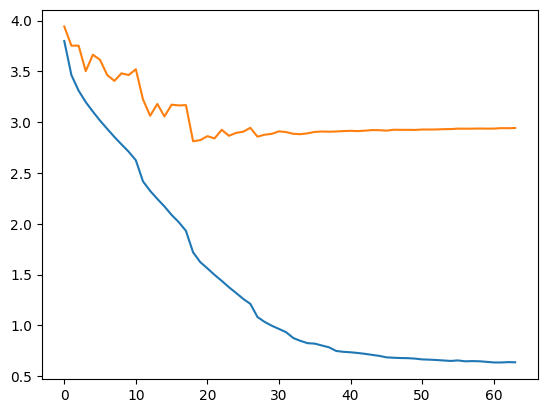

In [53]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

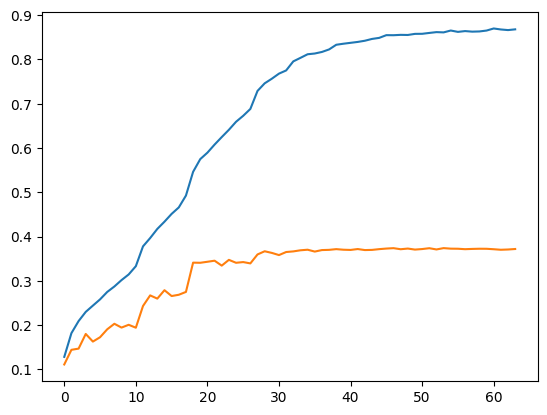

In [54]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

## Test predictions

In [ ]:
predictions = model.predict(x_test)

103/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

W0000 00:00:1718804908.337087     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
predictions = predictions.argmax(axis=1)

In [ ]:
predictions

array([46, 42, 15, ..., 51, 50,  0])

In [ ]:
df = pd.DataFrame(predictions, columns=["Label"])

In [ ]:
df.index.name = "Id"

In [ ]:
df.head()

,Label
Id,
0,46
1,42
2,15
3,5
4,71


In [ ]:
df.to_csv("submission.csv")